# 🧠 Predicting Customer Churn Using Random Forests
Welcome to this practical machine learning exercise. In this notebook, you'll develop a solution for predicting customer churn — a classic and highly practical problem in economics, management, and business analytics.

**Goal:** Apply machine learning to identify customers at risk of leaving (churning), using historical data.

Along the way, you'll:
- Preprocess data responsibly (avoiding leakage)
- Train and evaluate models
- Build pipelines for cleaner workflows
- Tune models using validation sets
- Deploy a final product-ready solution

This notebook emphasizes **intuitive understanding**, **real-world practices**, and links to **further resources**.

**Note:** Documentation links are provided extensively, to help you, in the following format:
  - [📘 StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

**Note: Whenever you see the ✍️ symbol, it means you must fill in the blanks with your own code!**

## ⚙️ Step 0: Setup

Before we begin, we load the core Python libraries used for:
- **Data manipulation** (`pandas`, `numpy`)
- **Visualization** (`matplotlib`, `seaborn`)
- **Modeling and preprocessing** (`sklearn`)

We'll also be using the **scikit-learn** machine learning library throughout this notebook — make sure to check the documentation links provided at each step.

In [1]:
# Common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and modeling tools
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

## 📊 Step 1: Load the Data

The dataset contains customer data from a (fictional) telecom company. Each row is a customer, and each column is an attribute describing that customer’s usage patterns or account features.

You are given a **train set** and a **test set** (pre-split). This setup simulates a situation where you're developing a model using historical data and then testing how well it might generalize to new customers.

In [4]:
# Load data
# ✍️ Load the the training set into df_train and the test set into df_test.
df_train = pd.read_csv('churn_train.csv')
df_test = pd.read_csv('churn_test.csv')

## 🎯 Step 2: Understand the Problem — Classification
This is a **binary classification problem**: each customer either **churns** (`Churn = Yes`) or **stays** (`Churn = No`).

**Class imbalance:** Only ~14% of customers are churners. This will affect how we train and evaluate the model.

📌 We'll address this through evaluation metrics like precision and recall.

In [5]:
# Separate features and target
# ✍️ Split df_train into X_train and y_train; do the same for df_test.
X_train = df_train.drop('Churn', axis=1)
y_train = df_train['Churn']
X_test = df_test.drop('Churn', axis=1)
y_test = df_test['Churn']

## 🧹 Step 3: Preprocessing — Manual (Leakage-Free)

Preprocessing is where most real-world ML effort goes. We must:
1. Encode **categorical** features numerically (for the model).
2. Scale **numerical** features to help model convergence.
3. Avoid **data leakage**: Never use information from the test set to preprocess the training set!

📌 We'll handle categorical and numeric features **separately** and then combine them.

In [7]:
# Identify feature types
# ✍️ Create a list variable named categorical_features, containing the names of all categorical feature columns.
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
print('Categorical features:', categorical_features)

# ✍️ Create a list variable named numeric_features, containing the names of all numeric feature columns.
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
print('Numerical features:', numeric_features)



Categorical features: ['State', 'International plan', 'Voice mail plan']
Numerical features: ['Account length', 'Area code', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls']


In [11]:
# Manual preprocessing
# ✍️ Fit a OneHotEncoder to the training set, but apply it to both the training and test set!
# 💡 Hint: Recall the difference between the `fit`, `transform` and `fit_transform` methods.
# ❗ Important! Use `sparse=False` or `sparse_output=False` (depending on the version of sklearn you're using)
# when initializing your OneHotEncoder! It will be important later!


# ✍️ Now fit a StandardScaler to the training set, but apply it to both the training and test set!

# OneHotEncoder for categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_cat = encoder.fit_transform(X_train[categorical_features])
X_test_cat = encoder.transform(X_test[categorical_features])

# StandardScaler for numerical features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numeric_features])
X_test_num = scaler.transform(X_test[numeric_features])

# Print the shapes to verify
print('Encoded categorical training data shape:', X_train_cat.shape)
print('Encoded categorical test data shape:', X_test_cat.shape)
print('Scaled numerical training data shape:', X_train_num.shape)
print('Scaled numerical test data shape:', X_test_num.shape)


Encoded categorical training data shape: (2666, 55)
Encoded categorical test data shape: (667, 55)
Scaled numerical training data shape: (2666, 16)
Scaled numerical test data shape: (667, 16)


In [12]:
# We now combine the numerical and categorical features:
# ℹ️ This wouldn't have worked without `sparse=False`!
# Combine the numerical and categorical features
X_train_final = np.hstack([X_train_num, X_train_cat])
X_test_final = np.hstack([X_test_num, X_test_cat])

# Print shapes to verify the combination
print("Final training data shape:", X_train_final.shape)
print("Final test data shape:", X_test_final.shape)


Final training data shape: (2666, 71)
Final test data shape: (667, 71)


🎓 **Why this matters**:

- **StandardScaler** rescales features to mean 0 and standard deviation 1, making tree-based models faster and more robust.
  - [📘 StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

- **OneHotEncoder** converts categorical variables into binary vectors.
  - [📘 OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

✍️ **Your Turn**: Combine the categorical and numeric processed arrays with `np.hstack(...)` to get `X_train_final` and `X_test_final`.

## 🌲 Step 4: Random Forest Training

**Random Forests** are one of the most versatile and powerful classifiers, especially for tabular data.

They are:
- **Ensemble models** made of many decision trees.
- Resistant to overfitting thanks to randomness.
- Handle both categorical (after encoding) and numeric features well.

[📘 RandomForestClassifier Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [14]:
# Train a Random Forest classifier
# ✍️ Create a new RandomForestClassifier and assign it the a variable named `model`.
# ✍️ Fit your RandomForestClassifier in the training set.

# Train a Random Forest classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_final, y_train)

RandomForestClassifier(random_state=42)

## 📊 Step 5: Evaluation on Held-Out Test Set

To estimate how well your model might perform in production, use a **test set that the model hasn’t seen**.

Use:
- [📘 accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
- [📘 classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

📌 **Reminder**: With class imbalance, accuracy can be misleading. Look at **precision, recall, and F1 score** as well.

In [15]:
# Evaluate on test set
# ✍️ Save the prediction of your model on the test set to `y_pred`.

# ✍️ Print the accuracy score your model got.

# ✍️ Print a classification report for your model.

# Evaluate on test set
y_pred = model.predict(X_test_final)

# Print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Print a classification report
print('Classification Report:\n', classification_report(y_test, y_pred))


Accuracy: 0.9445277361319341
Classification Report:
               precision    recall  f1-score   support

       False       0.94      1.00      0.97       572
        True       0.98      0.62      0.76        95

    accuracy                           0.94       667
   macro avg       0.96      0.81      0.86       667
weighted avg       0.95      0.94      0.94       667



## 🔁 Step 6: Use Pipelines

Manual preprocessing is error-prone. Use [📘 Pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to:

- Bundle preprocessing and modeling together.
- Reduce leakage risk.
- Improve reproducibility.

We'll use [📘 ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to apply different preprocessing to numeric and categorical features.

📚 Read more:
- [📘 sklearn Pipelines Tutorial](https://scikit-learn.org/stable/modules/compose.html)
- [📝 Blog Post](https://towardsdatascience.com/how-to-use-columntransformer-for-numerical-and-categorical-data-6d8cbd25f4b6)

In [16]:
# Use sklearn pipeline
# ✍️ Create a ColumnTransformer object, made up of a StandardScaler followed by a OneHotEncoder object.
#❗ Important! Remember to use `sparse=False` or `sparse_output=False`.


# ✍️ Now create a Pipeline object made up of your column transformer object and a RandomForestClassifier object.


# ✍️ Fit your pipeline object on the training set, then predict results for the test set
# and produce a classification report.


# Create a ColumnTransformer object
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
])

# Create a Pipeline object
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the pipeline on the training set
pipeline.fit(X_train, y_train)

# Predict results for the test set
y_pred_pipeline = pipeline.predict(X_test)

# Print the accuracy score
accuracy_pipeline = accuracy_score(y_test, y_pred_pipeline)
print('Pipeline Accuracy:', accuracy_pipeline)

# Print a classification report
print('Pipeline Classification Report:\n', classification_report(y_test, y_pred_pipeline))


Pipeline Accuracy: 0.9445277361319341
Pipeline Classification Report:
               precision    recall  f1-score   support

       False       0.94      1.00      0.97       572
        True       0.98      0.62      0.76        95

    accuracy                           0.94       667
   macro avg       0.96      0.81      0.86       667
weighted avg       0.95      0.94      0.94       667



## 🔍 Step 7: Manual Hyperparameter Tuning

To make better models, tune key hyperparameters. We’ll try different values for `max_depth`.

We'll use a **train-validation-test** split:
- **Train**: build models
- **Validation**: compare models
- **Test**: final performance estimate

[📘 train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [22]:
# Let's unite the training and validation sets into one big set:
df_full = pd.concat([df_train, df_test], ignore_index=True)
X = df_full.drop("Churn", axis=1)
y = df_full["Churn"]

# Print the shape to verify
print("Combined dataset shape:", X.shape, y.shape)

Combined dataset shape: (3333, 19) (3333,)


In [23]:
# Train-validation-test split for tuning
# We use train_test_split to get a three-way split: Firstg into trainval and test;
# then we split trainval into train and validation.
X_trainval, X_test_final, y_trainval, y_test_final = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval)



# Print the shapes to verify the split
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test_final.shape, y_test_final.shape)


Training set shape: (1999, 19) (1999,)
Validation set shape: (667, 19) (667,)
Test set shape: (667, 19) (667,)


In [25]:
# Manual hyperparameter tuning
# ✍️ Manually find the best value for the max_depth hyperparameter out of [5, 10, 15, 20]:
# 💡 Hint: Use a for loop to iterate over a list of possible values. Then, for each such value,
# create a new pipeline with the appropriate value for RandomForestClassifier (you DON'T have to
# create your ColumnTransformer again; use the same object you've already created), fit it on the
# training set and evaluate it on the **validation set**! Do NOT touch the test set in this loop!

# Manual hyperparameter tuning
best_accuracy = 0
best_depth = None

for depth in [5, 10, 15, 20]:
    # Create a pipeline with the current max_depth
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', RandomForestClassifier(max_depth=depth, random_state=42))
    ])

    # Fit the pipeline on the training set
    pipeline.fit(X_train, y_train)

    # Predict on the validation set
    y_val_pred = pipeline.predict(X_val)

    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_val_pred)
    print(f'Max Depth: {depth} | Validation Accuracy: {accuracy}')

    # Update best model if current model is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_depth = depth

print(f'Best max_depth: {best_depth} with accuracy: {best_accuracy}')


Max Depth: 5 | Validation Accuracy: 0.8785607196401799
Max Depth: 10 | Validation Accuracy: 0.9325337331334332
Max Depth: 15 | Validation Accuracy: 0.9400299850074962
Max Depth: 20 | Validation Accuracy: 0.9475262368815592
Best max_depth: 20 with accuracy: 0.9475262368815592


## ✅ Step 8: Final Evaluation and Deployment-Ready Model

After choosing the best hyperparameter from the validation set, retrain your model on **train+val** and evaluate on **test**.

Then, retrain a final version on **all labeled data** to use in production.

You can save the model for future use using:
[📘 sklearn model persistence](https://scikit-learn.org/stable/model_persistence.html)

### 8.1: Final Evaluation

Final Model Accuracy: 0.9370314842578711
Final Model Classification Report:
               precision    recall  f1-score   support

       False       0.93      1.00      0.96       570
        True       0.98      0.58      0.73        97

    accuracy                           0.94       667
   macro avg       0.96      0.79      0.85       667
weighted avg       0.94      0.94      0.93       667



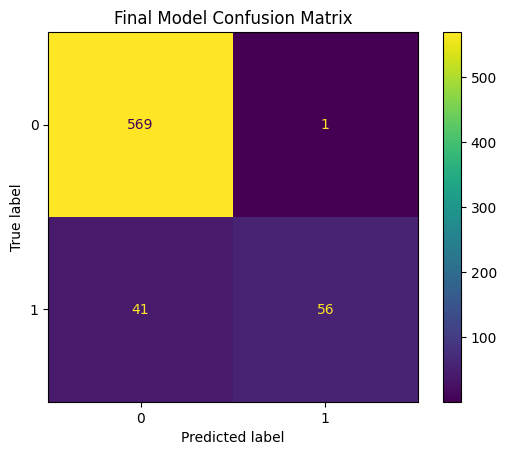

In [31]:
# Final model evaluation
# ✍️ Now create the pipeline again, now with max_depth set to the value which showed the
# best results. Then, fit it on the **X_trainval** set, and predict on the test set.
# What is the model performance? That's our estimate for future performamce.

# Final model evaluation
# Create the pipeline with the best max_depth found
final_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(max_depth=best_depth, random_state=42))
])

# Fit the pipeline on the combined training+validation set
final_pipeline.fit(X_trainval, y_trainval)

# Predict on the test set
y_test_pred = final_pipeline.predict(X_test_final)

# Print the accuracy score
final_accuracy = accuracy_score(y_test_final, y_test_pred)
print('Final Model Accuracy:', final_accuracy)

# Print a classification report
print('Final Model Classification Report:\n', classification_report(y_test_final, y_test_pred))

# Plot the confusion matrix
final_cm = confusion_matrix(y_test_final, y_test_pred)
ConfusionMatrixDisplay(final_cm).plot()
plt.title('Final Model Confusion Matrix')
plt.show()

### 💬 Answer the following questions:
- Are there more false positives or false negatives?
- Which mistake is more costly in your business scenario?
- Should you tune the model to favor precision or recall?

|                | חיזוי: לא נטש (0) | חיזוי: נטש (1) |
|---------------|-----------------|---------------|
| **לא נטש (0)** | 569             | 1             |
| **נטש (1)**    | 41              | 56            |

---

### **תשובות לשאלות:**  

1. **האם יש יותר חיוביים שגויים (False Positives) או שליליים שגויים (False Negatives)?**  
   - **False Positives (FP):** 1  
   - **False Negatives (FN):** 41  
   - **תשובה:** יש יותר **שליליים שגויים (FN)** - המודל פספס יותר לקוחות נוטשים.  

---

2. **איזו טעות יקרה יותר בתרחיש העסקי?**  
   - **הטעות היקרה יותר היא FN (שלילי שגוי):**  
     - לקוח שעומד לעזוב ולא זוהה על ידי המודל, לא יזכה לפעולות שימור מצד החברה.  
     - זה עלול לגרום לאובדן לקוח יקר, ולכן זו טעות קריטית יותר.  

---

3. **האם כדאי לכוון את המודל להעדיף דיוק (Precision) או שליפה (Recall)?**  
   - **עדיף להעדיף Recall (שליפה):**  
     - חשוב יותר לזהות את כל הלקוחות שעומדים לנטוש, גם אם זה אומר שיש כמה FP נוספים.  
     - במקרה שלנו, המודל מצליח לזהות 56 לקוחות שנוטשים אך מפספס 41 - ניתן לשפר את ה-Recall על חשבון ה-Precision.  



### 🧪 Sub-Task: Plot the Confusion Matrix

The **confusion matrix** helps you visually assess where your model is getting things right or wrong.

It breaks predictions into:
- **True Positives (TP)**: correctly predicted churners.
- **True Negatives (TN)**: correctly predicted non-churners.
- **False Positives (FP)**: predicted churn but customer stayed.
- **False Negatives (FN)**: predicted stay but customer churned.

This can help you **understand your model's trade-offs**, especially when classifying rare events (like churn).

📘 Documentation:
- [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
- [sklearn.metrics.ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)

✍️ **Your task**: Use `ConfusionMatrixDisplay.from_predictions(...)` to plot the matrix.

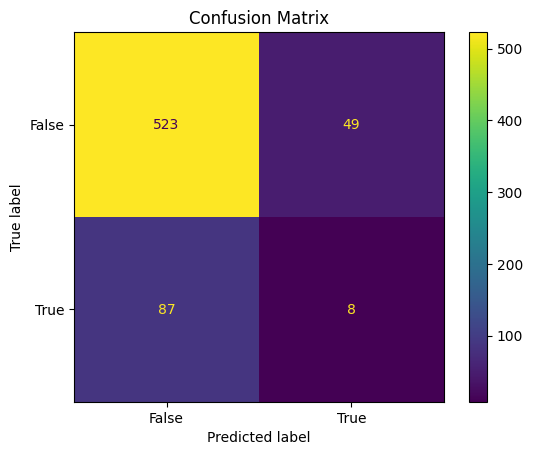

In [30]:
# Plot confusion matrix
# ✍️ Use ConfusionMatrixDisplay.from_predictions().

# Plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Plot the confusion matrix using from_predictions
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.title('Confusion Matrix')
plt.show()

### 8.2: Train the final model

In [29]:
# Train final product-ready model
# ✍️ Now create the pipeline again, one last time. Fit it on the entire dataset (X and y variables).
# That's it! You're done! Great job!

# Train final product-ready model
# Create the pipeline one last time
final_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(max_depth=best_depth, random_state=42))
])

# Fit the pipeline on the entire dataset (X and y)
final_pipeline.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Account length',
                                                   'Area code',
                                                   'Number vmail messages',
                                                   'Total day minutes',
                                                   'Total day calls',
                                                   'Total day charge',
                                                   'Total eve minutes',
                                                   'Total eve calls',
                                                   'Total eve charge',
                                                   'Total night minutes',
                                                   'Total night calls',
                                                   'Total night charge',
                                                   'Total intl minutes',
                                                   'Total intl calls',
                                                   'Total intl charge',
                                                   'Customer service calls']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['State',
                                                   'International plan',
                                                   'Voice mail plan'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=20, random_state=42))])